<a href="https://colab.research.google.com/github/HammadN98/Modulo3-Bootcamp/blob/main/Notebook/Projeto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de previsão temporal usando o Prophet

O Projeto tem como objetivos::
  - 1 Explorar 
  - 2 Analisar
  - 3 E a contrução de um modelo de previsão
 

In [21]:
# Importações e pre-setings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import fbprophet
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import matplotlib.dates as mdates


In [12]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (15,8)
sns.set_theme(style="darkgrid", palette="Set2")
# sns.color_palette("Set2")

## Exploração

Devido ao tamanho dos dados usados, eles já foram manipulados antes deste notebook. Para conter apenas o dados relacionados a cidade de Da cidade de São José do Rio Preto  



In [3]:

url_rio_preto = 'https://raw.githubusercontent.com/HammadN98/Modulo3-Bootcamp/main/Dados/dados_esse.csv'


In [4]:
dados = pd.read_csv(url_rio_preto)
dados.head()

,city,city_ibge_code,date,epidemiological_week,estimated_population,estimated_population_2019,is_last,is_repeated,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,order_for_place,place_type,state,new_confirmed,new_deaths
0,São José do Rio Preto,3549805.0,2020-03-18,202012,464983.0,460671.0,False,False,1,0.21506,2020-03-18,0.0,0,1,city,SP,1,0
1,São José do Rio Preto,3549805.0,2020-03-19,202012,464983.0,460671.0,False,False,1,0.21506,2020-03-19,0.0,0,2,city,SP,0,0
2,São José do Rio Preto,3549805.0,2020-03-20,202012,464983.0,460671.0,False,False,1,0.21506,2020-03-20,0.0,0,3,city,SP,0,0
3,São José do Rio Preto,3549805.0,2020-03-21,202012,464983.0,460671.0,False,True,1,0.21506,2020-03-20,0.0,0,4,city,SP,0,0
4,São José do Rio Preto,3549805.0,2020-03-22,202013,464983.0,460671.0,False,True,1,0.21506,2020-03-20,0.0,0,5,city,SP,0,0


In [5]:
dados.dtypes


city                                              object
city_ibge_code                                   float64
date                                              object
epidemiological_week                               int64
estimated_population                             float64
estimated_population_2019                        float64
is_last                                             bool
is_repeated                                         bool
last_available_confirmed                           int64
last_available_confirmed_per_100k_inhabitants    float64
last_available_date                               object
last_available_death_rate                        float64
last_available_deaths                              int64
order_for_place                                    int64
place_type                                        object
state                                             object
new_confirmed                                      int64
new_deaths                     

In [6]:
# Se tratando de uma analise temporal, já estou mudando o tipo do dado date agora no inicio
dados['date'] =  pd.to_datetime(dados['date'], format='%Y-%m-%d')


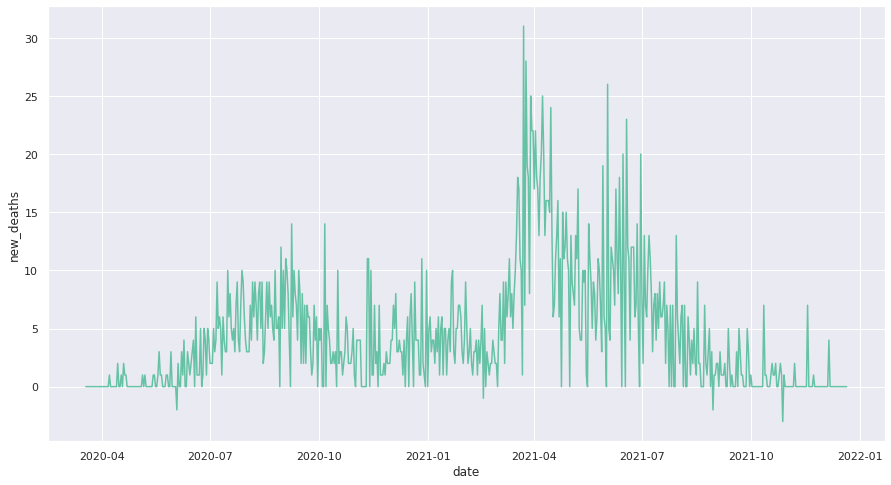

In [14]:
sns.lineplot(data=dados, x='date', y='new_deaths')
plt.show()


Como se pode notar no grafico exitem dias em que ouve um numero de negativo de mortes. Algo que eu creio não ser possivel, logo sera tratado como erro de digitação e o sinal negativo será removido.

In [15]:
dados["new_deaths"].replace({-1: 1, -2: 2, -3:3}, inplace=True)


### Taxa de mortes

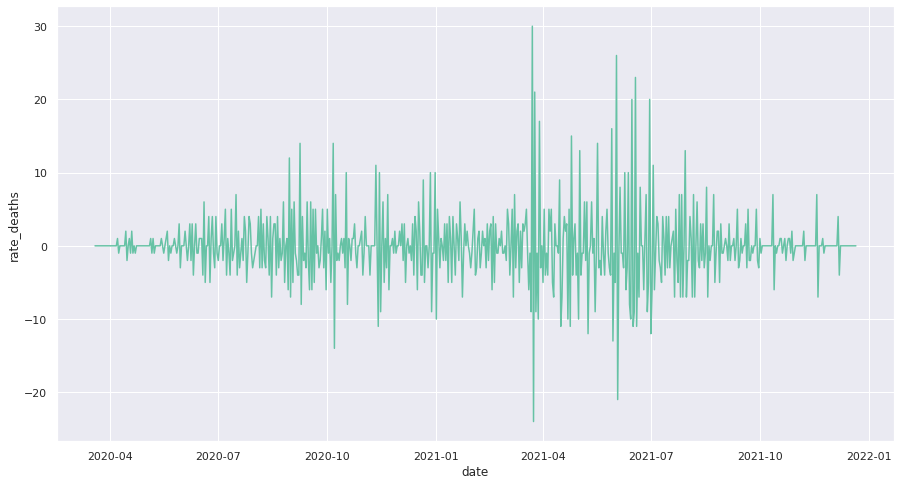

In [16]:
dados["rate_deaths"] = dados["new_deaths"].diff()
sns.lineplot(data=dados, x='date', y='rate_deaths')


### Media movel das mortes

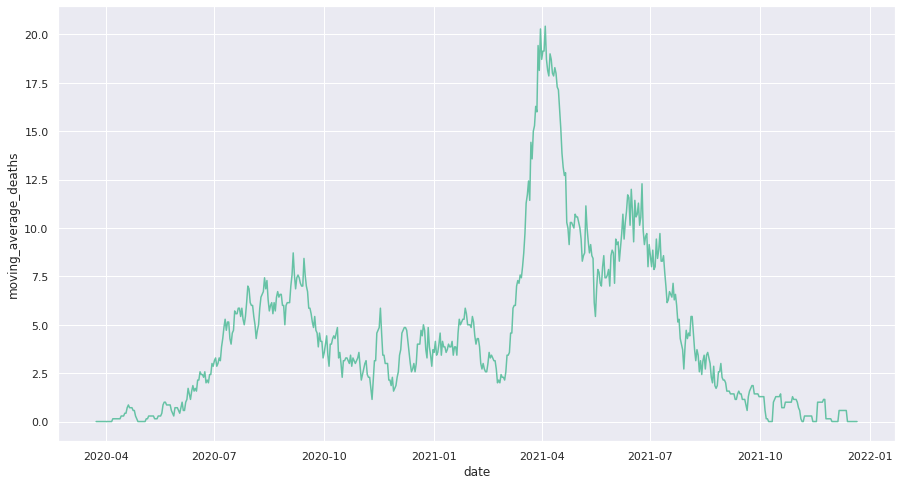

In [17]:
dados['moving_average_deaths'] = dados['new_deaths'].rolling(window=7, center=False).mean()
sns.lineplot(data=dados, x='date', y='moving_average_deaths')


#### Novas mortes junto da media movel das mortes

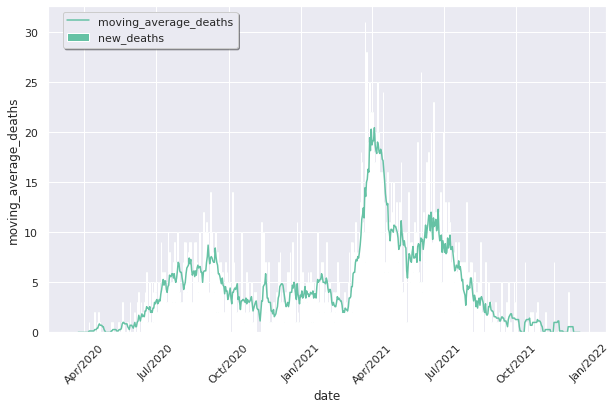

In [33]:
fig, ax=plt.subplots(figsize=(10,6))

ax.bar(dados['date'], dados['new_deaths'])
sns.lineplot(data=dados, x='date', y='moving_average_deaths')

ax.axes.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.legend(('moving_average_deaths','new_deaths'), shadow=True, bbox_to_anchor=(0.35,1))


plt.xticks(rotation=45)
plt.show()


#### verificando a autocorrelação

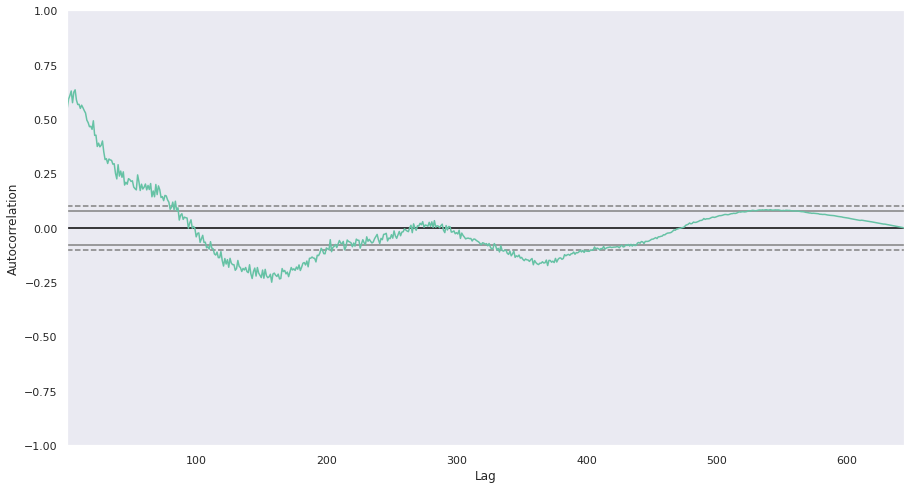

In [20]:
autocorrelation_plot(dados['new_deaths'])


## Explorando com o Prophet

In [34]:
import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [35]:
dados.shape


(644, 20)

#### Criação dos dataframes de treino e teste
- Sera usado 80/20 para treino/teste

In [36]:
df_treino = pd.DataFrame()
df_treino['ds'] = dados['date'][:520]
df_treino['y'] = dados['new_deaths'][:520]

df_teste = pd.DataFrame()
df_teste['ds'] = dados['date'][520:]
df_teste['y'] = dados['new_deaths'][520:]

In [38]:
# feriados 
feriados_rio_preto_2020= [
'2020-03-19',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-08',
'2020-12-25'
]

feriados_rio_preto_2021= [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-19',
'2021-04-02',
'2021-04-21',
'2021-05-01',
'2021-06-03',
'2021-07-09',
'2021-09-07',
'2021-10-12',
'2021-11-02',
'2021-11-15',
'2021-12-08',
'2021-12-25',
]
# add feriados 114
feriados_rio_preto_2020 = pd.DataFrame({'holiday' : 'rio_preto_2020',
                                 'ds' : pd.to_datetime(feriados_rio_preto_2020)})
feriados_rio_preto_2021 = pd.DataFrame({'holiday' : 'sp_2021',
                                 'ds' : pd.to_datetime(feriados_rio_preto_2021)})
feriados = pd.concat((feriados_rio_preto_2020, feriados_rio_preto_2021))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


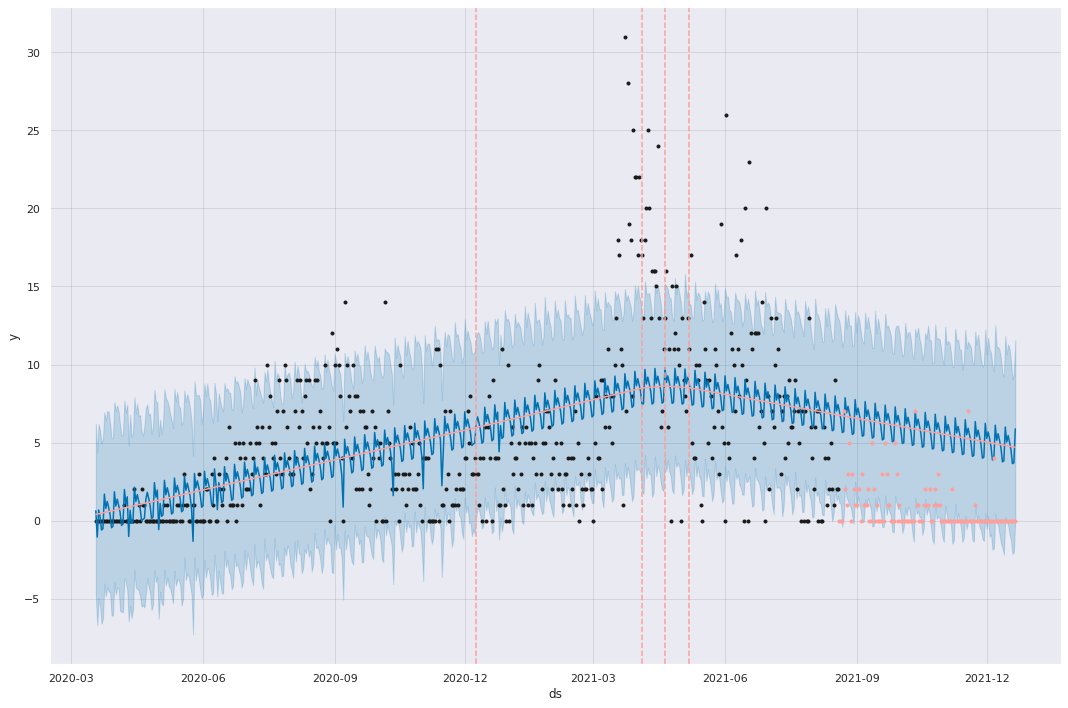

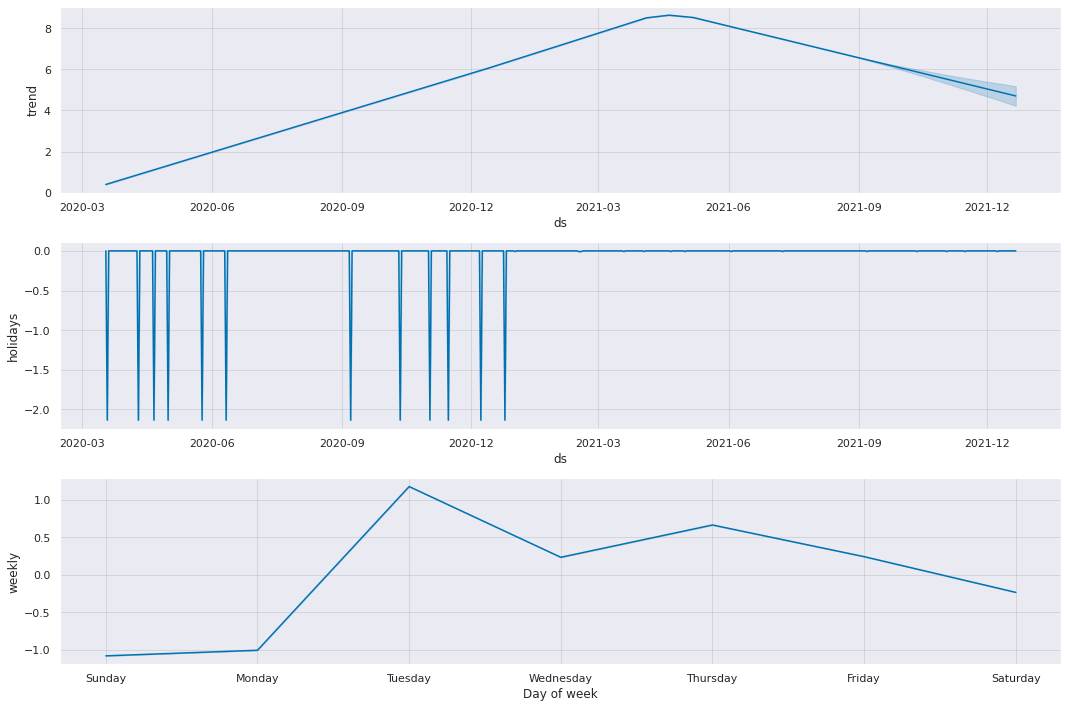

In [115]:
modelo_feriados = Prophet(holidays=feriados)
modelo_feriados.fit(df_treino)
dataframefuturo = modelo_feriados.make_future_dataframe(periods=124)
previsao = modelo_feriados.predict(dataframefuturo)
fig = modelo_feriados.plot(previsao, figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), modelo_feriados, previsao)

plt.plot(df_teste['ds'], df_teste['y'],'.r')

modelo_feriados.plot_components(previsao, figsize=(15,10));

#### Antes da remooção de outliers, será feita a decisão do modelo de ser multiplicativo ou aditivio

In [78]:
from sklearn.metrics import mean_absolute_error

Escolha entre aditiva e multiplicativa:

In [80]:
# Aditiva
mean_absolute_error(df_treino['y'], previsao['yhat'][:520])

3.1841834553222657

In [114]:
# multiplicativa 
modelo_feriados = Prophet(changepoint_prior_scale=10.0, seasonality_mode='multiplicative')
modelo_feriados.fit(df_treino)
dataframefuturo_feriados = modelo_feriados.make_future_dataframe(periods=124)
previsao = modelo_feriados.predict(dataframefuturo_feriados)
mean_absolute_error(df_treino['y'], previsao['yhat'][:520])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2.2535896356644836

#### Remoção de outliers

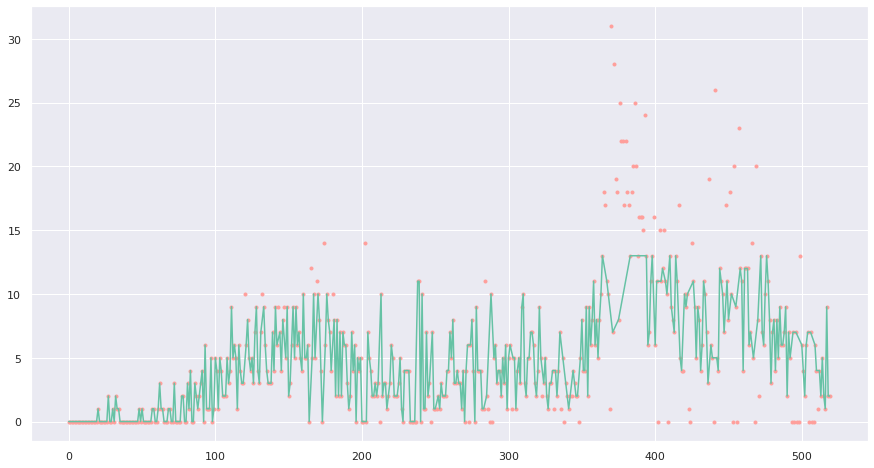

In [63]:
sem_out = df_treino.reset_index()
sem_out = sem_out[(sem_out['y'] > previsao['yhat_lower'][:520]) & (sem_out['y'] < previsao['yhat_upper'][:520])]
plt.plot(df_treino.index, df_treino['y'], 'r.')
plt.plot(sem_out['index'], sem_out['y'])


In [65]:
df_sem_out = sem_out[['ds', 'y']]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


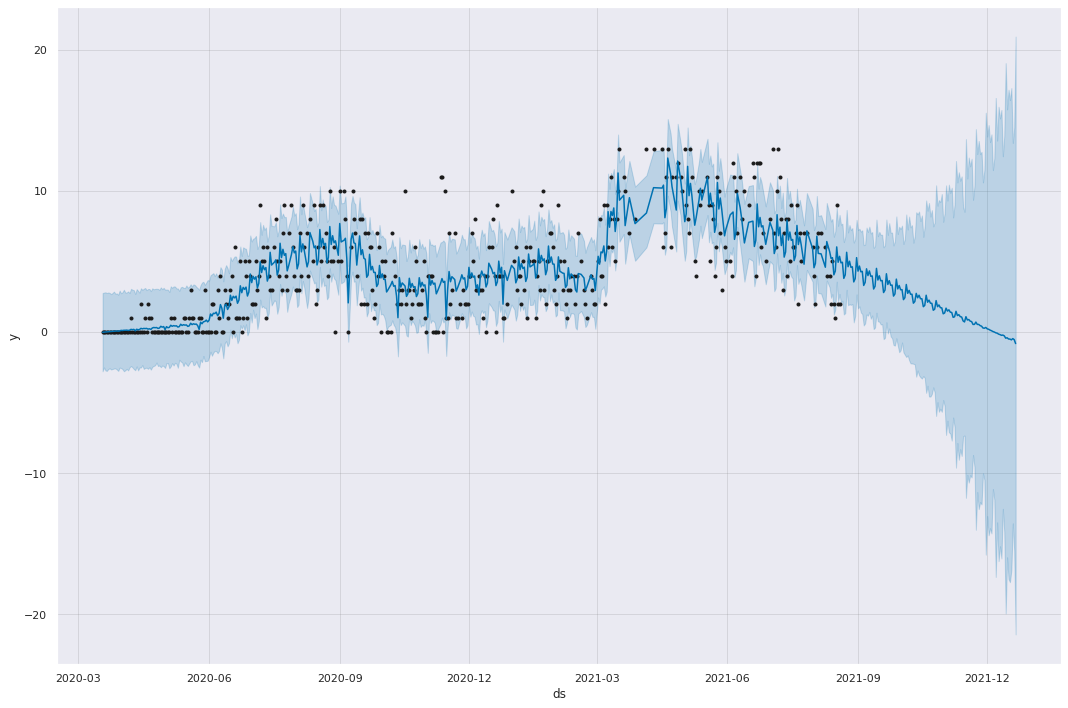

In [113]:
modelo_feriados = Prophet(changepoint_prior_scale=10.0, holidays=feriados, seasonality_mode='multiplicative')
modelo_feriados.fit(df_sem_out)
dataframefuturo = modelo_feriados.make_future_dataframe(periods=124)
previsao= modelo_feriados.predict(dataframefuturo)
fig= modelo_feriados.plot(previsao, figsize=(15,10))

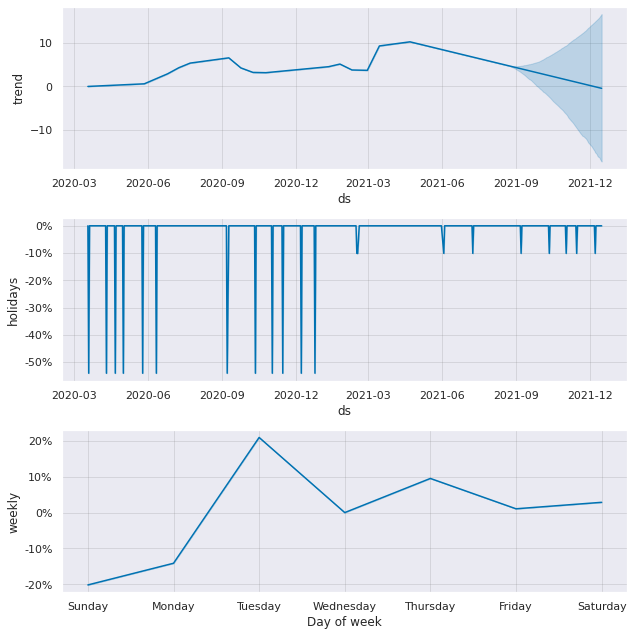

In [67]:
modelo_feriados.plot_components(previsao);



# Modelo final

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


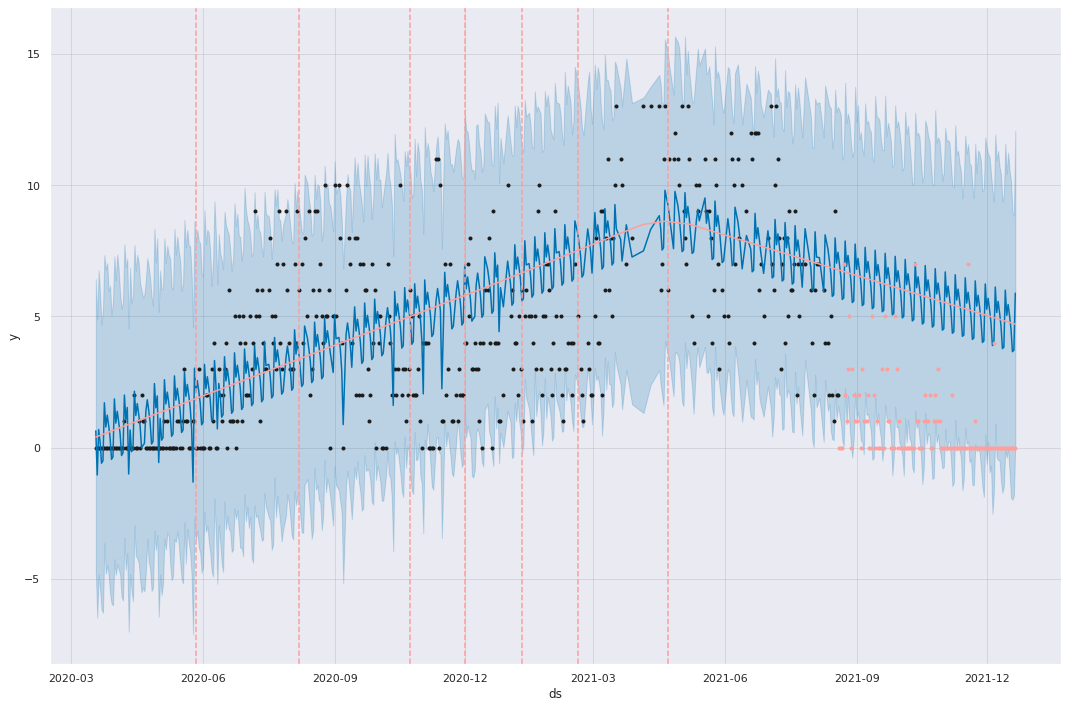

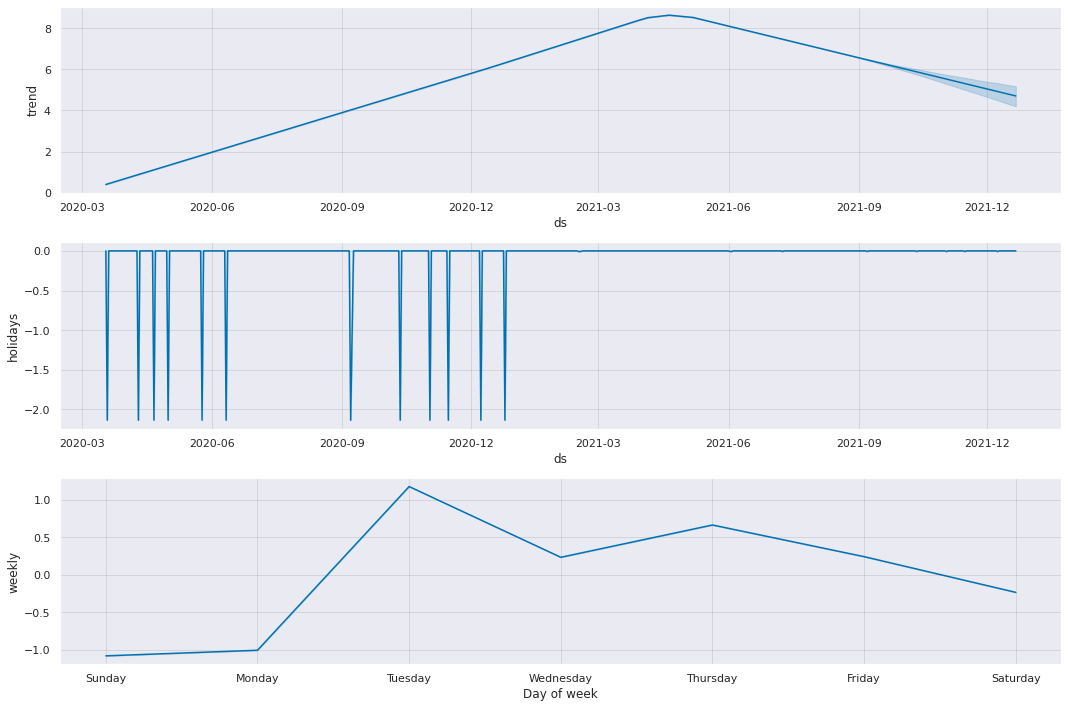

In [122]:
modelo_final = Prophet(n_changepoints=10, changepoint_prior_scale=0.5, holidays=feriados, seasonality_mode='multiplicative')
modelo_final.fit(df_sem_out)
dataframefuturo = modelo_final.make_future_dataframe(periods=124)
previsao_final = modelo_feriados.predict(dataframefuturo)
fig = modelo_final.plot(previsao_final, figsize=(15,10));
a = add_changepoints_to_plot(fig.gca(), modelo_final, previsao_final)

plt.plot(df_teste['ds'], df_teste['y'],'.r')

modelo_feriados.plot_components(previsao_final, figsize=(15,10));

#Metricas de validação

In [123]:
from fbprophet.diagnostics import cross_validation


In [124]:
df_cv = cross_validation(modelo_final, initial='180 days',period='30 days', horizon='30 days')

INFO:fbprophet:Making 11 forecasts with cutoffs between 2020-09-23 00:00:00 and 2021-07-20 00:00:00


  0%|          | 0/11 [00:00<?, ?it/s]

In [125]:
janela = 5
cutoff = df_cv['cutoff'].unique()[janela]
cutoff

numpy.datetime64('2021-02-20T00:00:00.000000000')

In [126]:
df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]


Text(0.5, 0, 'ds')

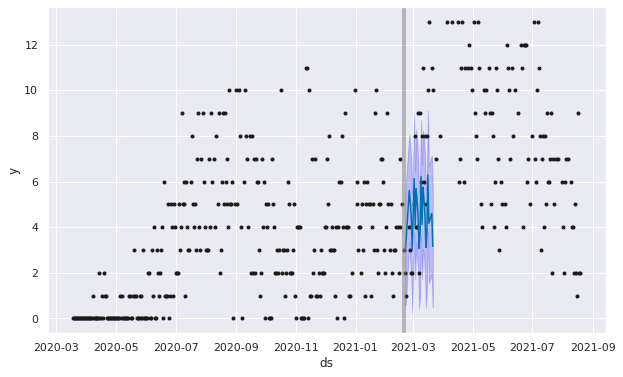

In [127]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(modelo_final.history['ds'].values, modelo_final.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

In [128]:
from fbprophet.diagnostics import performance_metrics

In [129]:
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,9.975170,3.158349,2.561537,0.516485,0.512000
1,4 days,6.313739,2.512716,2.085038,0.478536,0.560000
2,5 days,4.649290,2.156221,1.732670,0.275262,0.700000
3,6 days,4.973898,2.230224,1.825149,0.403645,0.657143
4,7 days,8.845906,2.974207,2.277756,0.448487,0.604444
5,8 days,8.991888,2.998648,2.328830,0.485931,0.555556
6,9 days,8.914691,2.985748,2.272613,0.509083,0.600000
7,10 days,7.972745,2.823605,2.137322,0.518476,0.645714
8,11 days,8.244895,2.871393,2.318089,0.491433,0.565714
9,12 days,9.536645,3.088146,2.616045,0.491433,0.457143


In [130]:
from fbprophet.plot import plot_cross_validation_metric

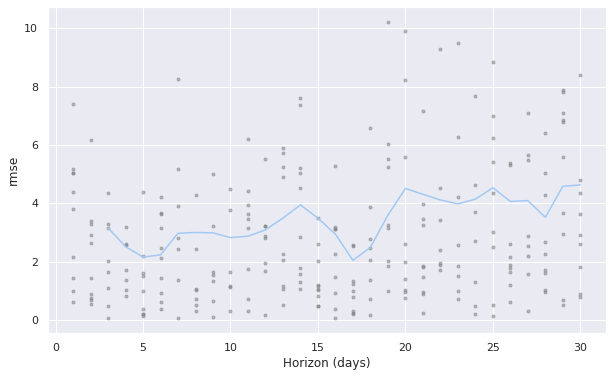

In [133]:
plot_cross_validation_metric(df_cv, metric='rmse');

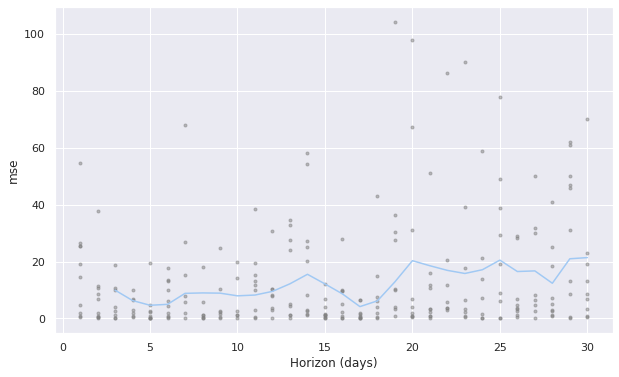

In [134]:
plot_cross_validation_metric(df_cv, metric='mse');




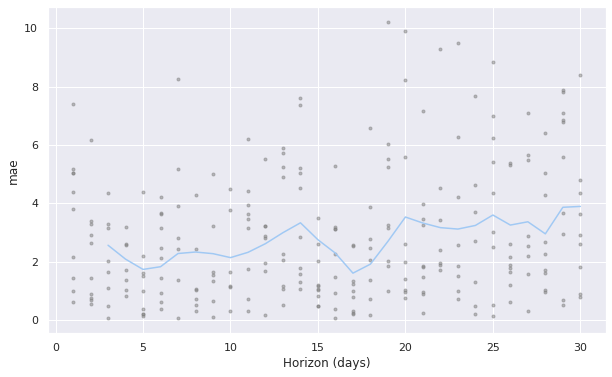

In [135]:
plot_cross_validation_metric(df_cv, metric='mae');


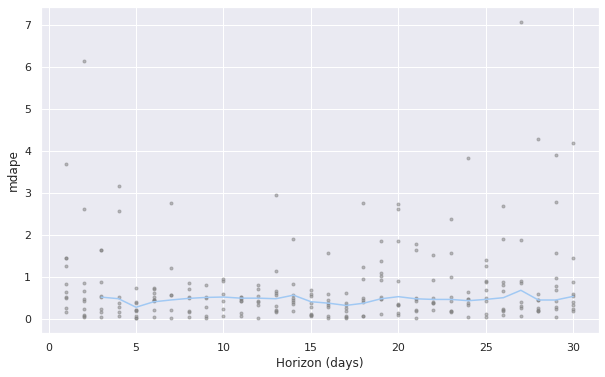

In [136]:

plot_cross_validation_metric(df_cv, metric='mdape');